
# <span style="color:rgb(213,80,0)">Using the CLASSIX Python package in MATLAB</span>

While we recommend using the [MATLAB version](https://github.com/nla-group/classix-matlab) of CLASSIX when working in MATLAB, there might be good reasons to call the [Python implementation](https://github.com/nla-group/classix-matlab) from within MATLAB too. For example, the Python version allows for density-based clustering which the MATLAB version doesn't, and it has seemless integration with pandas and other data sources. Here we demonstrate how to call the Python code directly from MATLAB.

## MATLAB and Python versions

When working with Python, it is suggested that you use the most recent version of MATLAB possible since the MATLAB-Python interoperability is improving quickly. Please refer to [Versions of Python Compatible with MATLAB](https://uk.mathworks.com/support/requirements/python-compatibility.html) to find out which Python versions are supported by your current MATLAB version. The best place to download a Python installation is [Download Python | Python.org](https://www.python.org/downloads/). Note that Python installations that come with the Anaconda or other distributions might not be fully supported.


We begin by ensuring that our Python environment is set up. The following command makes use of the system Python. Ensure that this version of Python has the CLASSIX clustering package installed. If this isn't the case, simply run **<samp>pip install classixclustering</samp>** on your command line. You might then have to restart MATLAB for the CLASSIX package to be available.


In [1]:
pe = pyenv()

pe = 
  PythonEnvironment with properties:
          Version: "3.11"
       Executable: "C:\Program Files\Python311\python.exe"
          Library: "C:\Program Files\Python311\python311.dll"
             Home: "C:\Program Files\Python311"
           Status: NotLoaded
    ExecutionMode: InProcess


It is also possible to use a venv Python environment. To do this, comment out the line above and uncomment the line below, changing the path to point to the Python executable in the version of Python you want to run.


In [2]:
% pe = pyenv(Version="C:\Program Files\Python311\python.exe")


Let's try a quick Python calculation to make sure the basics are all working OK.  All Python commands must be prefixed with **<samp>py.</samp>** So, to compute the Python command <samp>math.sqrt(42)</samp> we do:


In [3]:
py.math.sqrt(42)

ans = 6.4807

## A basic clustering analysis on MATLAB data using CLASSIX

Let's start by generating and plotting some data using MATLAB.



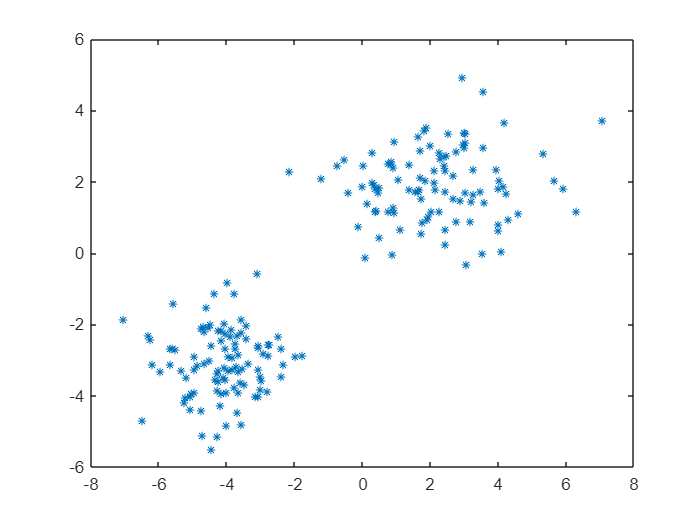

In [4]:
rng('default')        % For reproducibility
mu1 = [2 2];          % Mean of the 1st cluster
sigma1 = [2 0; 0 1];  % Covariance of the 1st cluster
mu2 = [-4 -3];        % Mean of the 2nd cluster
sigma2 = [1 0; 0 1];  % Covariance of the 2nd cluster
r1 = mvnrnd(mu1,sigma1,100);
r2 = mvnrnd(mu2,sigma2,100);
X = [r1; r2];
plot(X(:,1),X(:,2),"*",MarkerSize=5);


Calling CLASSIX is straightforward. We don't even need to convert the MATLAB array <samp>X</samp> to a Numpy array as it's all done automatically.


In [5]:
clx = py.classix.CLASSIX(radius=0.3, verbose=0);
clx = clx.fit(X);
clx.explain(plot=false);

CLASSIX clustered 200 data points with 2 features. 
The radius parameter was set to 0.30 and minPts was set to 0. 
As the provided data was auto-scaled by a factor of 1/4.03,
points within a radius R=0.30*4.03=1.21 were grouped together. 
In total, 548 distances were computed (2.7 per data point). 
This resulted in 28 groups, each with a unique group center. 
These 28 groups were subsequently merged into 4 clusters. 
For a visualisation of the clusters, use .explain(plot=True). 
In order to explain the clustering of individual data points, 
use .explain(ind1) or .explain(ind1, ind2) with data indices.


The cluster labels of each data point are available in <samp>clx.labels</samp>_. This is a Numpy array:


In [6]:
class(clx.labels_)

ans = 'py.numpy.ndarray'


but no conversion is required when using this in the MATLAB <samp>scatter</samp> command:



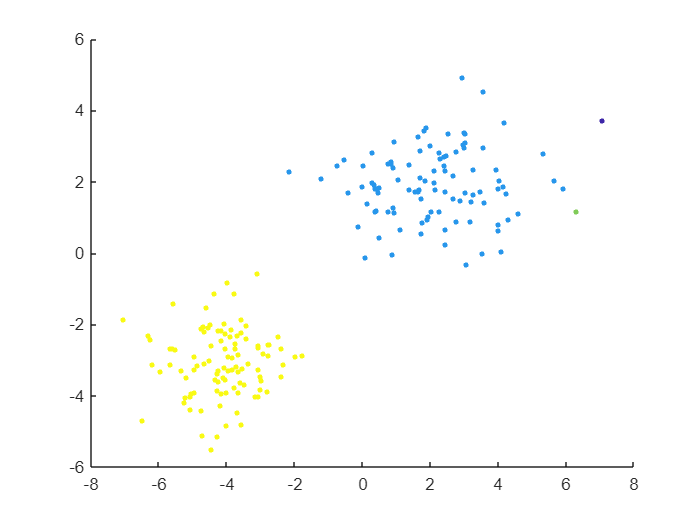

In [7]:
scatter(X(:,1),X(:,2),10,clx.labels_,"filled");

## More complex use cases and data conversion notes

Note that in the above clustering, CLASSIX found 4 clusters when we know the ground truth had 2. Two of those 'clusters' only had one data point in them though. We could use the <samp>minPts</samp> option to ensure that this does not happen. However, our first attempt results in an error message:


In [8]:
clx = py.classix.CLASSIX(radius=0.3, minPts=10, verbose=0);

Error using clustering>minPts
Python Error: TypeError: unsupported operand type(s) for &: 'float' and 'float'
Error in clustering>__init__ (line 394)


The reason for this is that in MATLAB a literal number such as <samp>10</samp> is of type double whereas in Python it is an integer. We need to be more explicit and make use of <samp>int32():</samp>



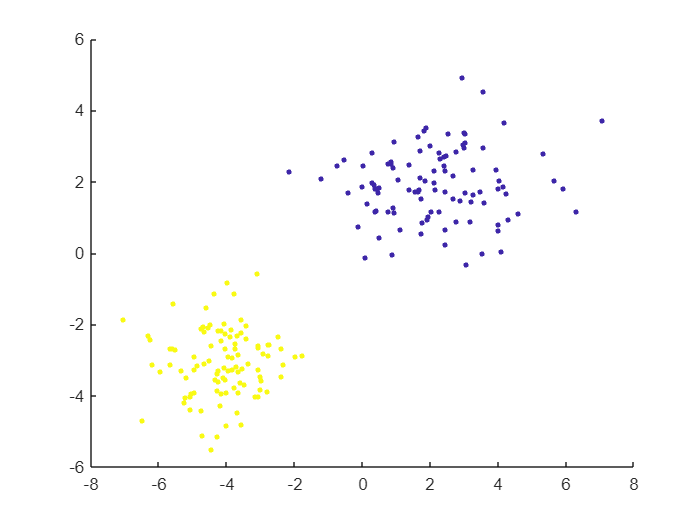

In [9]:
clx = py.classix.CLASSIX(radius=0.3, minPts=int32(10), verbose=0);
clx.fit(X);
scatter(X(:,1),X(:,2),10,clx.labels_,"filled");


Now, it looks like we have 2 clusters. The CLASSIX <samp>explain()</samp> method confirms this:


In [10]:
clx.explain(plot=false)

CLASSIX clustered 200 data points with 2 features. 
The radius parameter was set to 0.30 and minPts was set to 10. 
As the provided data was auto-scaled by a factor of 1/4.03,
points within a radius R=0.30*4.03=1.21 were grouped together. 
In total, 548 distances were computed (2.7 per data point). 
This resulted in 28 groups, each with a unique group center. 
These 28 groups were subsequently merged into 2 clusters. 
For a visualisation of the clusters, use .explain(plot=True). 
In order to explain the clustering of individual data points, 
use .explain(ind1) or .explain(ind1, ind2) with data indices.

## CLASSIX explainability and plotting from Python

A key feature of CLASSIX is that it can provide textual explanations of the computed clustering results, making it a fully explainable clustering algorithm. The CLASSIX <samp>explain()</samp> method can also produce plots, but you may receive an error message when attempting to do this from MATLAB:


In [11]:
clx.explain(plot=true, showallgroups=true)

CLASSIX clustered 200 data points with 2 features. 
The radius parameter was set to 0.30 and minPts was set to 10. 
As the provided data was auto-scaled by a factor of 1/4.03,
points within a radius R=0.30*4.03=1.21 were grouped together. 
In total, 548 distances were computed (2.7 per data point). 
This resulted in 28 groups, each with a unique group center. 
These 28 groups were subsequently merged into 2 clusters. 
For a visualisation of the clusters, use .explain(plot=True). 
In order to explain the clustering of individual data points, 
use .explain(ind1) or .explain(ind1, ind2) with data indices.


This is explained on MATLAB Answers at [Why am I not able to call python Tkinter in MATLAB? - MATLAB Answers - MATLAB Central (mathworks.com)](https://uk.mathworks.com/matlabcentral/answers/808595-why-am-i-not-able-to-call-python-tkinter-in-matlab?s_tid=srchtitle). We need to provide paths to TCL.


In [12]:
% You'll need to find the correct paths on your machine.
setenv('TCL_LIBRARY', 'C:\Program Files\Python311\tcl\tcl8.6')
setenv('TK_LIBRARY', 'C:\Program Files\Python311\tcl\tk8.6')
clx.explain(plot=true, showallgroups=true)

CLASSIX clustered 200 data points with 2 features. 
The radius parameter was set to 0.30 and minPts was set to 10. 
As the provided data was auto-scaled by a factor of 1/4.03,
points within a radius R=0.30*4.03=1.21 were grouped together. 
In total, 548 distances were computed (2.7 per data point). 
This resulted in 28 groups, each with a unique group center. 
These 28 groups were subsequently merged into 2 clusters. 
For a visualisation of the clusters, use .explain(plot=True). 
In order to explain the clustering of individual data points, 
use .explain(ind1) or .explain(ind1, ind2) with data indices.


The plot opens in a separate window and is not available inline in the live script. Here is the plot saved from the time I ran it on my machine:

<p style="text-align:left">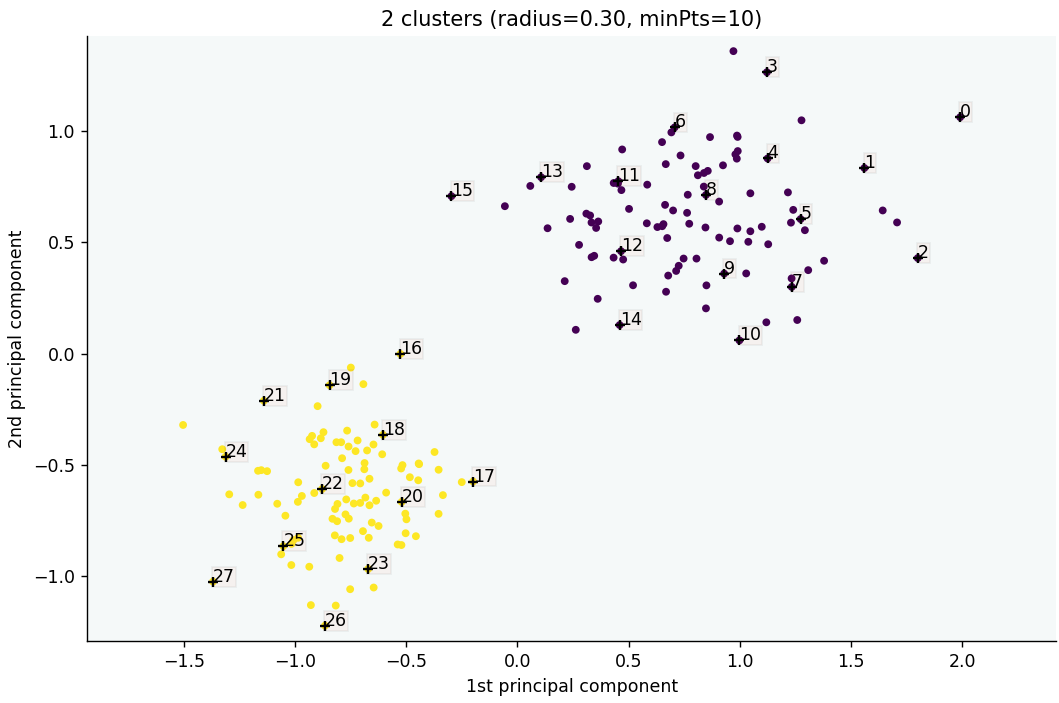</p>


Note how CLASSIX has identified 28 special data points labelled with numbers <samp>0,1,...,27</samp> in the above data plot. These special data points, called **group centers,** are all farther than <samp>radius</samp> apart from each other in the Euclidean norm (after some scaling of the data to make the results scaling invariant). Data points in the neighborhood of a group center form a  **group.** Each **cluster** is made up of one or more groups.


CLASSIX uses the groups to explain why data points ended up in the same cluster, or why they are in separate clusters. For example, we can ask CLASSIX why data point 1 and 99 are in the same cluster #0 as shown below.


**Important note:** You might have to manually close the separate graphics window from the previous section to proceed.


In [13]:
clx.explain(int32(1), int32(99), plot=true)

The data point 1 is in group 5 and the data point 99 is in group 13, 
both of which were merged into cluster #0. 
These two groups are connected via groups 5 <-> 8 <-> 11 <-> 13.


<p style="text-align:left">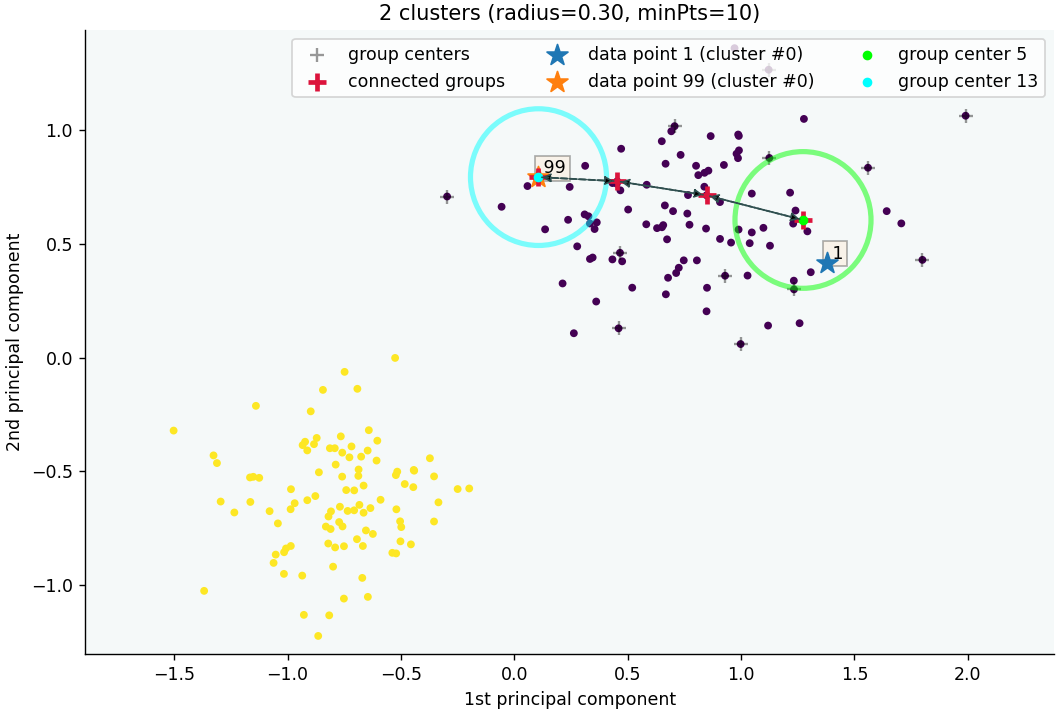</p>


CLASSIX explains that data point 1 is in group 5, and data point 99 is in group 13, and there is a connecting path via groups 8 and 11 between these groups. In other words, we can go from data point 1 to 99 in three steps of length at most \texttt{1.5*radius} without leaving cluster #0. This is also shown visually in the above plot, with the groups 5-8-11-13 connected by a path.

## Interactive use with Live Controls

Now we have everything working, we can explore the clustering options using interactive live controls. You'll only see these in the live script version, not the Jupyter notebook version.



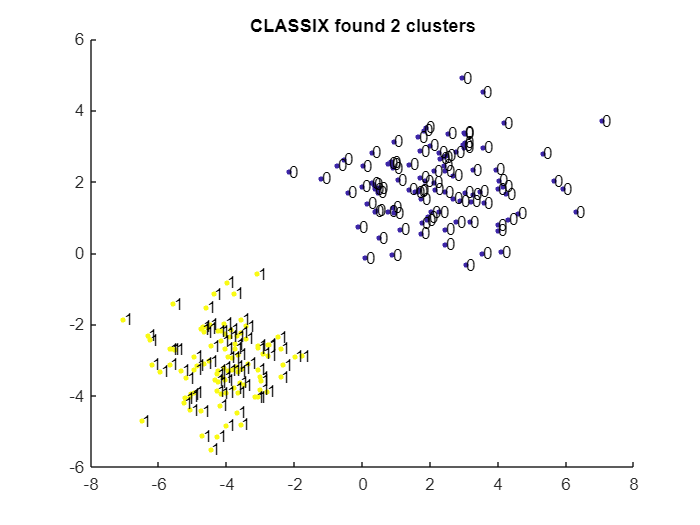

In [14]:
radius = 0.41;
minPts = 6;
showClusterNumbers = true;

clx = py.classix.CLASSIX(radius=radius, verbose=0, minPts=int32(minPts));
clx = clx.fit(X);
scatter(X(:,1),X(:,2),10,clx.labels_,"filled");
hold on
if showClusterNumbers
    labels = double(clx.labels_);
    for i=1:size(X,1)
        text(X(i,1),X(i,2),num2str(labels(i)));
    end
end
title(sprintf("CLASSIX found %d clusters",max(clx.labels_)+1))
hold off

## What is CLASSIX?

CLASSIX is a fast and memory-efficient clustering algorithm which produces explainable results. It exploits an initial sorting of the data points along their first principal axis to quickly assign data points to groups, followed by the merging of groups into clusters. In contrast to clustering methods like DBSCAN, CLASSIX does use any tree-based data structures to perform nearest-neighbor searches. In fact, CLASSIX's memory requirement grows only linearly in the number of data points. In contrast to the popular k-means algorithm, which is tailored to spherical clusters, CLASSIX can detect clusters of arbitrary shape.


If you'd like to learn more about CLASSIX, here are a couple of online references:

-  arXiv paper: [https://arxiv.org/abs/2202.01456](https://arxiv.org/abs/2202.01456)
-  Python code: [https://github.com/nla-group/classix](https://github.com/nla-group/classix)
-  MATLAB code: [https://github.com/nla-group/classix-matlab/](https://github.com/nla-group/classix-matlab/)
-  YouTube video: [https://www.youtube.com/watch?v=K94zgRjFEYo](https://www.youtube.com/watch?v=K94zgRjFEYo)
